In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

import time

In [3]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = tf.keras.datasets.mnist.load_data()

train_x = raw_train_x/255
test_x = raw_test_x/255

train_x = train_x.reshape((60000, 28, 28, 1))
test_x = test_x.reshape((10000, 28, 28, 1))

train_y = raw_train_y
test_y = raw_test_y

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
model = keras.Sequential()
model.add(Input((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [5]:

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 10)                1

In [6]:
from tensorflow.keras import Model

input = Input((28,28,1))
x = Conv2D(32, (3,3))(input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(input, output)

In [7]:

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0     

In [8]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165
Receiving objects: 100% (2166/2166), 176.26 MiB | 25.39 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Checking out files: 100% (2144/2144), done.


In [9]:
!head 'Houses-dataset/Houses Dataset/HousesInfo.txt'

4 4 4053 85255 869500
4 3 3343 36372 865200
3 4 3923 85266 889000
5 5 4022 85262 910000
3 4 4116 85266 971226
4 5 4581 85266 1249000
3 4 2544 85262 799000
4 5 5524 85266 1698000
3 4 4229 85255 1749000
4 5 3550 85262 1500000


In [10]:
import matplotlib

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [11]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

def load_house_attributes(inputPath):

	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
 
	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()
 
	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)
   
	# return the data frame
	return df

def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]

	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])
 
	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoding, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])
 
	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])
 
	# return the concatenated training and testing data
	return (trainX, testX)  

In [12]:
def load_house_images(df, inputPath):

	# initialize our images array (i.e., the house images themselves)
	images = []

	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		housePaths = sorted(list(glob.glob(basePath)))
  
		# initialize our list of input images along with the output image
		# after *combining* the four input images
		inputImages = []
		outputImage = np.zeros((64*4, 64*4, 3), dtype="uint8")
  
		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be 32 32, and then
			# update the list of input images
			image = cv2.imread(housePath)
			image = cv2.resize(image, (32*4, 32*4))
			inputImages.append(image)
   
		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0*4:32*4, 0*4:32*4] = inputImages[0]
		outputImage[0*4:32*4, 32*4:64*4] = inputImages[1]
		outputImage[32*4:64*4, 32*4:64*4] = inputImages[2]
		outputImage[32*4:64*4, 0*4:32*4] = inputImages[3]

		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)
  
	# return our set of images
	return np.array(images)  

In [13]:
df = load_house_attributes("Houses-dataset/Houses Dataset/HousesInfo.txt")
df.head()

,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000
80,4,2.5,2464,91901,599000
81,2,2.0,1845,91901,529800


In [14]:
images = load_house_images(df, "Houses-dataset/Houses Dataset/")
images = images/255.
print(images.shape)

(362, 256, 256, 3)


In [15]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)
print("tainAttrX.shape=", trainAttrX.shape)
print("trainImagesX.shape=", trainImagesX.shape)
print("trainY.shape=", trainY.shape)
print("testAttrX.shape=", testAttrX.shape)
print("testImageX.shape=", testImagesX.shape)
print("testY.shape=", testY.shape)

tainAttrX.shape= (271, 10)
trainImagesX.shape= (271, 256, 256, 3)
trainY.shape= (271,)
testAttrX.shape= (91, 10)
testImageX.shape= (91, 256, 256, 3)
testY.shape= (91,)


In [16]:
# import the necessary packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate

In [17]:
input = Input(trainAttrX[0].shape)
x = Dense(10, activation='relu')(input)
x = Dense(10, activation='relu')(x)
output = Dense(1)(x)

attr_model = Model(input, output)
attr_model.compile(optimizer="adam", loss="mse")
attr_model.summary()

attr_model.fit(trainAttrX, trainY, epochs=100, verbose=0, batch_size=128)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [18]:
preds = attr_model.predict(testAttrX)

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 33.41%, std: 40.02


In [19]:
input = Input(trainImagesX[0].shape)
x = Conv2D(32, (3,3))(input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
output = Dense(1)(x)

image_model = Model(input, output)
image_model.compile(optimizer="adam", loss="mse")
image_model.summary()

image_model.fit(trainImagesX, trainY, epochs=100, verbose=0, batch_size=128)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 123008)            0   

In [20]:
preds = image_model.predict(testImagesX)

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 144.55%, std: 214.31


In [21]:
attr_input = Input(trainAttrX[0].shape)
x = Dense(10, activation='relu')(attr_input)
attr_out = Dense(10, activation='linear')(x)

image_input = Input(trainImagesX[0].shape)
x = Conv2D(32, (3,3))(image_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3))(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(10, activation='relu')(x)
image_output = Dense(10, activation='linear')(x)

combined_input = concatenate([attr_out, image_output])

x = Dense(4, activation="relu")(combined_input)
output = Dense(1)(x)


combined_model = Model([attr_input, image_input], output)
combined_model.compile(optimizer="adam", loss="mse")
combined_model.summary()

combined_model.fit([trainAttrX, trainImagesX], trainY, epochs=100, verbose=0, batch_size=128)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 254, 254, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 127, 127, 32  0          ['conv2d_6[0][0]']               
                                )                                                           

In [22]:
preds = combined_model.predict([testAttrX, testImagesX])

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

print("[INFO] mean: {:.2f}%, std: {:.2f}".format(mean, std))

[INFO] mean: 73.23%, std: 70.71


In [23]:
!wget https://github.com/dhrim/cau_2022_summer/raw/master/material/deep_learning/fashion_dataset.zip

--2022-07-25 01:25:14--  https://github.com/dhrim/cau_2022_summer/raw/master/material/deep_learning/fashion_dataset.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/cau_2022_summer/master/material/deep_learning/fashion_dataset.zip [following]
--2022-07-25 01:25:14--  https://raw.githubusercontent.com/dhrim/cau_2022_summer/master/material/deep_learning/fashion_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26991216 (26M) [application/zip]
Saving to: ‘fashion_dataset.zip’

fashion_dataset.zip 100%[===================>]  25.74M  --.-KB/s    in 0.08s   

2022-07-25 01:25:15 (31

In [24]:
!ls -alh

total 26M
drwxr-xr-x 1 root root 4.0K Jul 25 01:25 .
drwxr-xr-x 1 root root 4.0K Jul 25 01:13 ..
drwxr-xr-x 4 root root 4.0K Jul 13 13:42 .config
-rw-r--r-- 1 root root  26M Jul 25 01:25 fashion_dataset.zip
drwxr-xr-x 4 root root 4.0K Jul 25 01:23 Houses-dataset
drwxr-xr-x 1 root root 4.0K Jul 13 13:43 sample_data


In [25]:
!unzip fashion_dataset.zip

Archive:  fashion_dataset.zip
   creating: fashion_dataset/
   creating: fashion_dataset/black_jeans/
  inflating: fashion_dataset/black_jeans/00000000.jpg  
   creating: __MACOSX/
   creating: __MACOSX/fashion_dataset/
   creating: __MACOSX/fashion_dataset/black_jeans/
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000000.jpg  
  inflating: fashion_dataset/black_jeans/00000004.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000004.jpg  
  inflating: fashion_dataset/black_jeans/00000006.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000006.jpg  
  inflating: fashion_dataset/black_jeans/00000007.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000007.jpg  
  inflating: fashion_dataset/black_jeans/00000009.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000009.jpg  
  inflating: fashion_dataset/black_jeans/00000010.jpg  
  inflating: __MACOSX/fashion_dataset/black_jeans/._00000010.jpg  
  inflating: fashion_dataset/black_jeans/000000

In [26]:
import matplotlib

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [1]:
IMAGE_DIMS = (96, 96, 3)

In [27]:
imagePaths = sorted(list(paths.list_images('fashion_dataset')))
random.shuffle(imagePaths)
print(len(imagePaths))
print(imagePaths[:3])

755
['fashion_dataset/red_shirt/00000069.jpg', 'fashion_dataset/red_dress/00000184.jpg', 'fashion_dataset/red_shirt/00000175.jpg']


In [28]:
data = []
categoryLabels = []
colorLabels = []

for imagePath in imagePaths:
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)

	(color, cat) = imagePath.split(os.path.sep)[-2].split("_")
  # imagePath = 'fashion_dataset/black_shoes/00000048.jpg'
  # color = 'black'
  # cat = 'shoes'
	categoryLabels.append(cat)
	colorLabels.append(color)
print(categoryLabels[:10])
print(colorLabels[:10])

['shirt', 'dress', 'shirt', 'shoes', 'dress', 'shirt', 'jeans', 'shirt', 'dress', 'shirt']
['red', 'red', 'red', 'black', 'blue', 'red', 'black', 'blue', 'blue', 'blue']


755 755 755
iamgePaths[0]= fashion_dataset/red_shirt/00000069.jpg


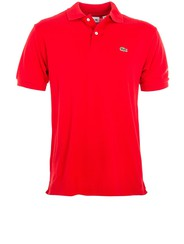

data[0]= (96, 96, 3)
categoryLabels[0]= shirt
colorLabels[0]= red


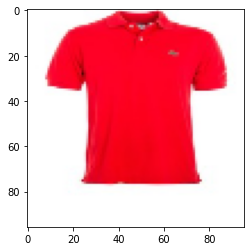

In [29]:
from IPython.display import Image, display

print(len(data), len(categoryLabels), len(colorLabels))
print("iamgePaths[0]=", imagePaths[0])
display(Image(imagePaths[0]))

print("data[0]=", data[0].shape)
plt.imshow(data[0]/255)
print("categoryLabels[0]=", categoryLabels[0])
print("colorLabels[0]=", colorLabels[0])

In [30]:
data = np.array(data, dtype="float")
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

# convert the label lists to NumPy arrays prior to binarization
categoryLabels = np.array(categoryLabels)
colorLabels = np.array(colorLabels)

[INFO] data matrix: 755 images (163.08MB)


In [31]:
data = data/255.

In [32]:
print(categoryLabels[:5])
categoryLB = LabelBinarizer()
categoryLabels = categoryLB.fit_transform(categoryLabels)
print(categoryLabels[:5])


print(colorLabels[:5])
colorLB = LabelBinarizer()
colorLabels = colorLB.fit_transform(colorLabels)
print(colorLabels[:5])

['shirt' 'dress' 'shirt' 'shoes' 'dress']
[[0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]
['red' 'red' 'red' 'black' 'blue']
[[0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 1 0]]


In [33]:
(trainX, testX, trainCategoryY, testCategoryY, trainColorY, testColorY) = train_test_split(data, categoryLabels, colorLabels, test_size=0.2, random_state=42)

print(trainX.shape)
print(trainCategoryY.shape)
print(trainColorY.shape)

print(testX.shape)
print(testCategoryY.shape)
print(testColorY.shape)

(604, 96, 96, 3)
(604, 4)
(604, 3)
(151, 96, 96, 3)
(151, 4)
(151, 3)


In [34]:
CATEGORY_COUNT = categoryLabels.shape[-1]
COLOR_COUNT = colorLabels.shape[-1]

print(CATEGORY_COUNT)
print(COLOR_COUNT)

4
3


In [35]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input


def build_category_model():

  model = keras.Sequential()
  model.add(Input(IMAGE_DIMS))
  model.add(Conv2D(32, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(CATEGORY_COUNT, activation='softmax'))

  return model

def build_color_model():

  model = keras.Sequential()
  model.add(Input(IMAGE_DIMS))
  model.add(Conv2D(32, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(COLOR_COUNT, activation='softmax'))

  return model  
print(trainX.shape)
print(trainCategoryY.shape)
print(CATEGORY_COUNT)

(604, 96, 96, 3)
(604, 4)
4


In [36]:
category_model = build_category_model()

category_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
category_model.summary()


category_model.fit(trainX, trainCategoryY, epochs=5, verbose=1, batch_size=128)


loss, acc = category_model.evaluate(testX, testCategoryY)
print("loss=",loss)
print("acc=",acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 30976)             0         
                                                                 
 dense_19 (Dense)            (None, 10)               

In [37]:
print(trainX.shape)
print(trainColorY.shape)
print(COLOR_COUNT)

(604, 96, 96, 3)
(604, 3)
3


In [38]:
color_model = build_color_model()

color_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
color_model.summary()


color_model.fit(trainX, trainColorY, epochs=5, verbose=1, batch_size=128)


loss, acc = color_model.evaluate(testX, testColorY)
print("loss=",loss)
print("acc=",acc)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 30976)             0         
                                                                 
 dense_22 (Dense)            (None, 10)               

In [39]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input


def common_input_branch(input):

  x = Conv2D(32, (3, 3))(input)
  x = MaxPooling2D((2, 2))(x)
  x = Conv2D(64, (3, 3))(x)
  x = MaxPooling2D((2, 2))(x)
  x = Flatten()(x)

  return x


def category_branch(x):

  x = Dense(10, activation='relu')(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(CATEGORY_COUNT, activation='softmax', name='category_output')(x)

  return x

def color_branch(x):

  x = Dense(10, activation='relu')(x)
  x = Dense(10, activation='relu')(x)
  x = Dense(COLOR_COUNT, activation='softmax', name='color_output')(x)

  return x
input = Input(IMAGE_DIMS)

common_input = common_input_branch(input)
category_output = category_branch(common_input)
color_output = color_branch(common_input)

multi_output_model = Model(input, [category_output, color_output])

multi_output_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 94, 94, 32)   896         ['input_9[0][0]']                
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 47, 47, 32)  0           ['conv2d_12[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 45, 45, 64)   18496       ['max_pooling2d_12[0][0]'] 

In [40]:
losses = { "category_output":"categorical_crossentropy", "color_output":"categorical_crossentropy"}
loss_weights = { "category_output":1.0, "color_output":1.0}

# color_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
multi_output_model.compile(optimizer="adam", loss=losses, loss_weights=loss_weights, metrics=["accuracy"])


# color_model.fit(trainX, trainColorY, epochs=5, verbose=1, batch_size=128)
multi_output_model.fit(trainX, {"category_output":trainCategoryY, "color_output":trainColorY}, epochs=50, verbose=1, batch_size=128)

Epoch 1/50
5/5 [==============================] - 1s 21ms/step - loss: 3.1540 - category_output_loss: 1.9965 - color_output_loss: 1.1575 - category_output_accuracy: 0.2483 - color_output_accuracy: 0.3228
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 2.7790 - category_output_loss: 1.3384 - color_output_loss: 1.4407 - category_output_accuracy: 0.3692 - color_output_accuracy: 0.5232
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 2.0721 - category_output_loss: 1.1367 - color_output_loss: 0.9354 - category_output_accuracy: 0.4801 - color_output_accuracy: 0.4106
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 1.7947 - category_output_loss: 1.0074 - color_output_loss: 0.7873 - category_output_accuracy: 0.5232 - color_output_accuracy: 0.6060
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 1.5316 - category_output_loss: 0.8758 - color_output_loss: 0.6558 - category_output_accuracy: 0.5844 - color_outp

In [41]:
loss, category_loss, color_loss, category_acc, color_acc = multi_output_model.evaluate(testX, {"category_output":testCategoryY, "color_output":testColorY})
print("loss=",loss)
print("categoyr_loss=", category_loss)
print("color_loss=", color_loss)
print("category_acc=", category_acc)
print("color_acc=", color_acc)

5/5 [==============================] - 0s 6ms/step - loss: 0.5308 - category_output_loss: 0.3414 - color_output_loss: 0.1894 - category_output_accuracy: 0.9272 - color_output_accuracy: 0.9735
loss= 0.5308271646499634
categoyr_loss= 0.3413828909397125
color_loss= 0.18944425880908966
category_acc= 0.9271523356437683
color_acc= 0.9735099077224731
